##Setup

In [ ]:
import os
import cv2
import json
import time
from random import shuffle
import csv
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, MaxPool2D, GlobalAveragePooling2D, Lambda, Conv2D, concatenate, ZeroPadding2D, Layer, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
import tensorflow_addons as tfa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/My Drive/data/research_MILDNet_tops_cropped.zip' '/content/'

In [ ]:
!cp '/content/drive/My Drive/16kimages.zip' '/content/'

In [ ]:
!unzip '/content/16kimages.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 16k_images/B01DVBZ888.jpeg  
  inflating: 16k_images/B01DW7DPKE.jpeg  
  inflating: 16k_images/B01DUJI0CW.jpeg  
  inflating: 16k_images/B01DWUL6JI.jpeg  
  inflating: 16k_images/B01E078EE2.jpeg  
  inflating: 16k_images/B01E099AYS.jpeg  
  inflating: 16k_images/B01DUNI89I.jpeg  
  inflating: 16k_images/B01DUPAOGG.jpeg  
  inflating: 16k_images/B01DX7YKK2.jpeg  
  inflating: 16k_images/B01DUA6MWQ.jpeg  
  inflating: 16k_images/B01E389QB8.jpeg  
  inflating: 16k_images/B01DWTUUDM.jpeg  
  inflating: 16k_images/B01E0G58M4.jpeg  
  inflating: 16k_images/B01DXWZB4G.jpeg  
  inflating: 16k_images/B01DWOMJ6S.jpeg  
  inflating: 16k_images/B01DWX5XDU.jpeg  
  inflating: 16k_images/B01DUQ11I0.jpeg  
  inflating: 16k_images/B01DXK603Y.jpeg  
  inflating: 16k_images/B01DTPBE2K.jpeg  
  inflating: 16k_images/B01DSCJWE6.jpeg  
  inflating: 16k_images/B01DQXRKQY.jpeg  
  inflating: 16k_images/B01DSCHNPQ.jpeg  
  inflating: 16k_images/B

In [ ]:
!unzip '/content/research_MILDNet_tops_cropped.zip'

Streaming output truncated to the last 5000 lines.
  inflating: tops_cropped/77096.jpg  
  inflating: tops_cropped/359501.jpg  
  inflating: tops_cropped/52605.jpg  
  inflating: tops_cropped/382999.jpg  
  inflating: tops_cropped/274873.jpg  
  inflating: tops_cropped/289072.jpg  
  inflating: tops_cropped/203029.jpg  
  inflating: tops_cropped/390522.jpg  
  inflating: tops_cropped/348798.jpg  
  inflating: tops_cropped/7870.jpg   
  inflating: tops_cropped/238276.jpg  
  inflating: tops_cropped/46680.jpg  
  inflating: tops_cropped/189723.jpg  
  inflating: tops_cropped/387827.jpg  
  inflating: tops_cropped/18785.jpg  
  inflating: tops_cropped/420665.jpg  
  inflating: tops_cropped/200983.jpg  
  inflating: tops_cropped/47601.jpg  
  inflating: tops_cropped/246926.jpg  
  inflating: tops_cropped/377163.jpg  
  inflating: tops_cropped/266268.jpg  
  inflating: tops_cropped/292368.jpg  
  inflating: tops_cropped/399316.jpg  
  inflating: tops_cropped/304601.jpg  
  inflating: tops_c

##Deployment Steps

![](https://drive.google.com/uc?export=view&id=1WVTSkqhOEKf8ooIGug9nB0fIBAUI59V0)

<h2> Explanation </h2>

1. **Base Model Training:** This is the part what we have seen in the previous notebook, where we build a pipeline and do full training based on the train set available, once this is done, we save our best model weights to a stroage bucket(ex: S3).
2. **Incremental Training:** This step is required when we have new set of images with us that are still not seen by our train set, this can be either weekly, monthly or quaterly. After doing the incremental training the updated model weights are again stored on storage bucket.
3. **Generate Embedding:** Once our training is done, we can generate embedding of all the images we have in our data repository, for this we need to first load all the images we have from data repository, and load the model weights and based on this generate final embedding.
4. **Cache DB:** In real world scenario if a user clicks on an image we need to show recommendation with very low latency, for this it is good to store your embedding in cache DB(example Redis), time taken by these to get records are much lesser than conventional DB, hence, in most of the production enviornment where latency matters, we prefer using such DBs.
5. **Recommendation:** Once all of our above steps are in place, if we have a query image, whose embedding we already have, it is passed through a similarity function, which will use the loaded embeddings from the cache DB to find the most similar products based on NN computed using some similairty(Ex: cosine similarity) and the user will see the recommended products along with the actual products.


##Implementation

<h1> Data Preparation to deploy </h1>

In [ ]:
def model_architecture():
  '''
  Ref: https://github.com/gofynd/mildnet/blob/master/trainer/model.py
  This function contains model architecture which will be used to generate final embedding for each image.
  model(output): Final model object
  '''
  pre_trained_model = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
  convnet = GlobalAveragePooling2D()(pre_trained_model.output)
  convnet = Dense(4096, activation = 'relu')(convnet)
  convnet = Dropout(0.5)(convnet)
  convnet = Dense(4096, activation = 'relu')(convnet)
  convnet = Dropout(0.5)(convnet)
  convnet = Lambda(lambda x : K.l2_normalize(x, axis = 1))(convnet)

  s1_inp = Input(shape = (224, 224, 3))
  s1 = MaxPool2D(pool_size = (4, 4), strides = (4, 4), padding = 'valid')(s1_inp)
  s1 = ZeroPadding2D(padding = (4, 4), data_format = None)(s1)
  s1 = Conv2D(96, kernel_size = (8, 8), strides = (4, 4), padding = 'valid')(s1)
  s1 = ZeroPadding2D(padding = (2, 2), data_format = None)(s1)
  s1 = MaxPool2D(pool_size = (7, 7), strides = (4, 4), padding = 'valid')(s1)
  s1 = Flatten()(s1)

  s2_inp = Input(shape = (224, 224, 3))
  s2 = MaxPool2D(pool_size = (8, 8), strides = (8, 8), padding = 'valid')(s2_inp)
  s2 = ZeroPadding2D(padding = (4, 4), data_format = None)(s2)
  s2 = Conv2D(96, kernel_size = (8, 8), strides = (4, 4), padding = 'valid')(s2)
  s2 = ZeroPadding2D(padding = (1, 1), data_format = None)(s2)
  s2 = MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = 'valid')(s2)
  s2 = Flatten()(s2)

  merge = concatenate([s1, s2])
  merge = Lambda(lambda x : K.l2_normalize(x, axis = 1))(merge)
  merge = concatenate([merge, convnet], axis = 1)
  embedding = Dense(4096)(merge)
  embedding = Lambda(lambda x : K.l2_normalize(x, axis = 1))(embedding)

  model = tf.keras.models.Model(inputs = [s1_inp, s2_inp, pre_trained_model.input], outputs = embedding)
  return model

In [ ]:
def get_image_path(path):
  '''
  This function is used in our case to read the data that we have in our test set
  It will read the test csv file that we have, return 2 separate list, one with 
  query images and other with images that we already have in system.
  '''
  query_image = []
  pos_image = []
  neg_image = []
  
  global img_path 
  with open(path) as csv_file:
    data = csv.reader(csv_file, delimiter = ',')
    for row in data:
      query_image.append(img_path + row[0])
      pos_image.append(img_path + row[1])
      neg_image.append(img_path + row[2])
  all_images = pos_image + neg_image

  return query_image, list(set(all_images))

Above function is a simple csv reader function, that actually reads the test file and generates list of query images and other images not part of query set....

In [ ]:
def query_embedding(query_image_path):
  '''
  This function returns image embedding for any query image based on the best model
  weights that are saved during training. 
  '''
  img = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(query_image_path), channels=3), [224, 224])
  img = tf.reshape(img, [1,224,224,3])
  return model((img, img, img))

For any query images, this function is called to generate the embedding corresponding to that image...

In [ ]:
def parser(input_tensor):
  '''
  This function can be used as a parser function for all the images we have that
  will be recommended to the user when the user will select a query image
  '''
  return tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor), channels=3), [224, 224])

This function is used by input pipeline function to map image paths and convert them into tensor representing an image

In [ ]:
def get_saved_images_embedding(data_path, batch_size = 128):
  '''
  This function is used to generate a pipeline that will be used to create a batch.
  Main purpose of having this is to overcome the RAM issue faced since we are using 
  everything on colab, in real world all our images will be stored in a bucket from where
  we can directly read them from their and pass on to model function to generate the 
  embedding which will be stored in a cache DB for low latency
  '''
  dataset = tf.data.Dataset.from_tensor_slices((np.array((data_path))))
  dataset = dataset.map(parser, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  return dataset

This is our input pipeline function that actually reads all the image paths and is used to finally generate embeddings for all the images already present in image repository

In [ ]:
#In these cells we are generating embedding for all images that we have
img_path = '/content/tops_cropped/'
query_lst, stored_images_list = get_image_path('/content/drive/My Drive/tops_test.csv')

model = model_architecture() # calling model architecture function
model.load_weights('/content/drive/My Drive/weight/epoch4model.h5') # Loading weights for model saved after 4th epoch

saved_images_data = get_saved_images_embedding(stored_images_list)
test_iterator = iter(saved_images_data)

#generating embeddings
test_data_lst = []
for _ in tqdm(range(len(stored_images_list) // 128)):
  test_data = test_iterator.get_next()
  test_data_lst.append(model((test_data, test_data, test_data)))
final_embedding = tf.concat(test_data_lst, axis = 0)
del test_data_lst

100%|██████████| 63/63 [00:52<00:00,  1.20it/s]


In above cell we started by defining the path where the images are present and then generated 2 list, one for query and rest of the images. Once this is done, we are loading weights of best model. Then coz of memory issue we iterate through the dataset with a batch size of 128 images to generate tensors of size 28, 4096. Finally we concat all these tensors to get embeddings for all the images that are part of our image repository....

<h1> Actual implementation based on similarity </h1>

In [ ]:
def cosine_distance(x, y):
  '''
  This function inputs 2 vector and calculates cosine distance.
  '''
  return np.dot(x, y)/(np.linalg.norm(x) * np.linalg.norm(y))

Above code is a simple implementation of cosine similarity, when given embeddings for 2 images, this will return how similar those images are, higher the value more similar the images are....

In [ ]:
def get_neighbours(train, query_embedding, k):
  '''
  This function finds the NN based on the cosine distance, it return top k NNs
  '''
  distance = [(index, cosine_distance(row, query_embedding)) for index, row in enumerate(train)]
  distance.sort(key = lambda x : x[1], reverse=True)
  return distance[0:k]

Above function is used to find the top 10 similar images for a query image. Given an images based on cosine similarity it'll give you the index of the image and the score it has with that query images, lastly based on the value of k it'll return the top k images similar to query image based on cosine similarity between image embeddings.....

In [ ]:
#For all the query images, generating 10 NN based on cosine similarity
nn_lst = []
for i in tqdm(range(len(query_lst))):
  nn_lst.append([(i, 1)] + get_neighbours(final_embedding.numpy(), query_embedding(query_lst[i]).numpy()[0], 10))

100%|██████████| 7000/7000 [18:49<00:00,  6.20it/s]


In above cell for all the images we are actually finding the top 10 NN and storing the results in a final list...

##Plotting results

Results on test set as seen in paper

![](https://drive.google.com/uc?export=view&id=1HjtdXoPgi-LQjsXXk4nzzdsM7s_z4U86)

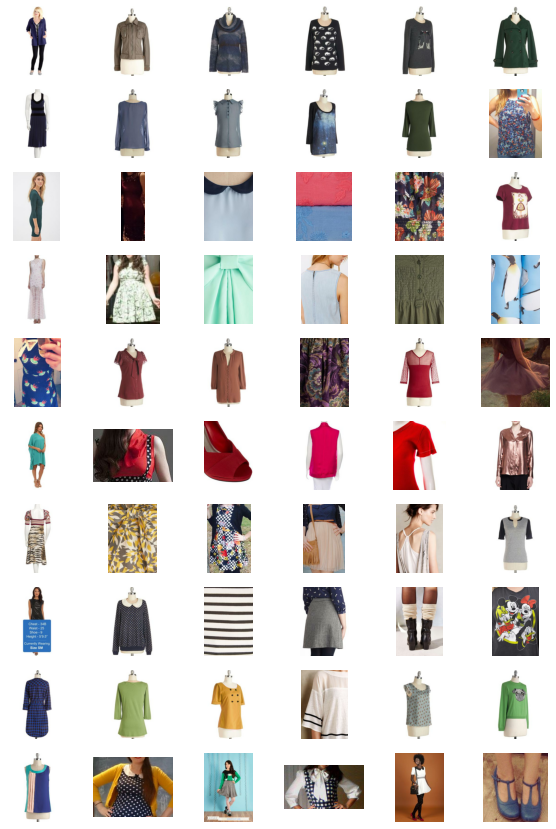

In [ ]:
fig=plt.figure(figsize=(10, 15))
shuffle(nn_lst) # Shuffling list
subplot_index = 1 #Creating an index element for sub plots

for items in nn_lst[0:10]: #choosing 10 samples
  for index in range(6):
    img = tf.image.decode_jpeg(tf.io.read_file(stored_images_list[items[index][0]]), channels=3)
    fig.add_subplot(10, 6, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()
#First image is the query image and the next 5 images are the result model gave...

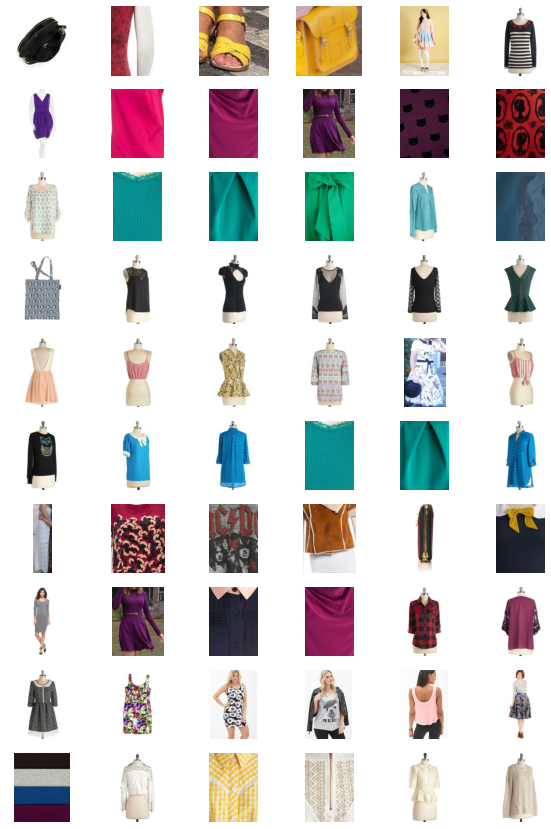

In [ ]:
fig=plt.figure(figsize=(10, 15))
shuffle(nn_lst)
subplot_index = 1
for items in nn_lst[0:10]:
  for index in range(6):
    img = tf.image.decode_jpeg(tf.io.read_file(stored_images_list[items[index][0]]), channels=3)
    fig.add_subplot(10, 6, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()

The test set that we have doesn't have many images, based on the type of images we have, model performance looks good, it is good to see that model is actually able to identify the color and also the pattern if any, deepest of variation in an image is being captued and recommendations are based on that only.

<h1> Taking amazon scrapped images </h1>

Since our images part of given set was not that rich in terms of similarity, Below cells contains testing of model on images from amazon.
These are some 16k images on which we'll try to see how our model is working...

In [ ]:
img_path = '/content/16k_images'
image_lst = ['{}/{}'.format(img_path, image) for image in os.listdir('/content/16k_images')]
#for image in os.listdir('/content/16k_images'):

model = model_architecture() # calling model architecture function
model.load_weights('/content/drive/My Drive/weight/epoch4model.h5') # Loading weights for model saved after 4th epoch

saved_images_data = get_saved_images_embedding(image_lst)
test_iterator = iter(saved_images_data)

test_data_lst = []
for _ in tqdm(range(len(image_lst) // 128)):
  test_data = test_iterator.get_next()
  test_data_lst.append(model((test_data, test_data, test_data)))
final_embedding = tf.concat(test_data_lst, axis = 0)
del test_data_lst

100%|██████████| 125/125 [01:45<00:00,  1.19it/s]


In this we'll generate embedding for all the 16k images....

In [ ]:
#For all the query images, generating 10 NN based on cosine similarity
nn_lst = []
for i in tqdm(range(len(image_lst))):
  nn_lst.append([(i, 1)] + get_neighbours(final_embedding.numpy(), query_embedding(image_lst[i]).numpy()[0], 10))

100%|██████████| 16032/16032 [1:20:46<00:00,  3.31it/s]


Now for each of these images, we are picking the top 10 similar images, like we did for other test data....

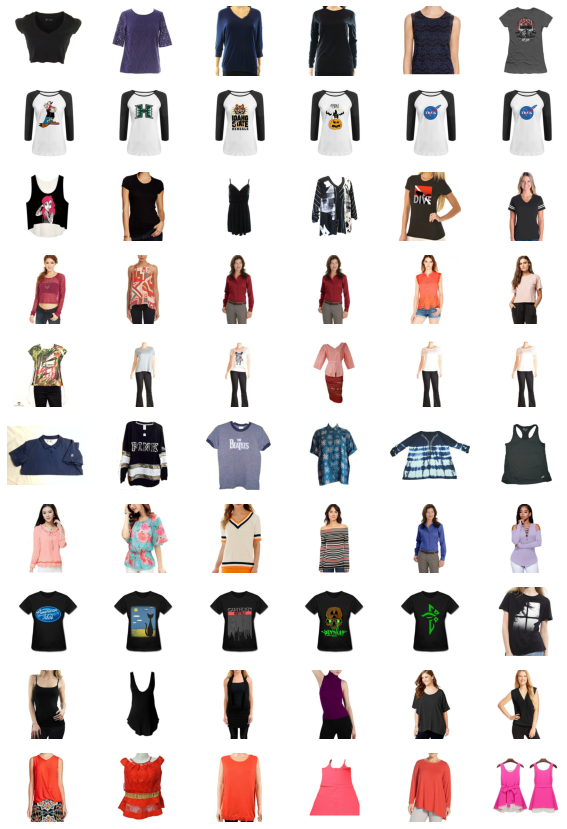

In [ ]:
fig=plt.figure(figsize=(10, 15))
shuffle(nn_lst)
subplot_index = 1

for items in nn_lst[0:10]:
  for index in range(1, 7): #Ignoring 1st image as that is same as the query, so plotting results from 2nd image
    img = tf.image.decode_jpeg(tf.io.read_file(image_lst[items[index][0]]), channels=3)
    fig.add_subplot(10, 6, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()

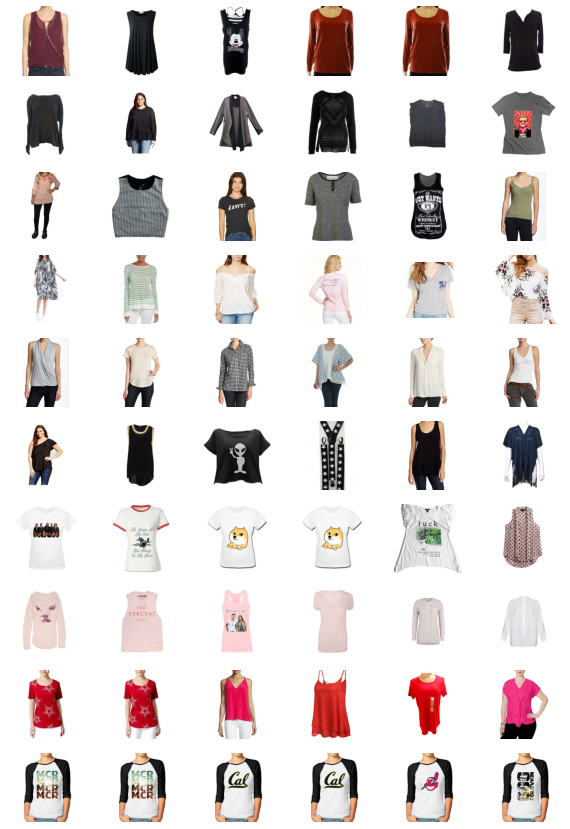

In [ ]:
fig=plt.figure(figsize=(10, 15))
shuffle(nn_lst)
subplot_index = 1
for items in nn_lst[0:10]:
  for index in range(1, 7):
    img = tf.image.decode_jpeg(tf.io.read_file(image_lst[items[index][0]]), channels=3)
    fig.add_subplot(10, 6, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()

From above we can say that if we have rich dataset then model's performance is actually good..... 